In [1]:
import pandas as pd
import os
import lighthouse_func as lf

Imported v0.1.901. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [2]:
 #분류/회귀
project = '107' # 프로젝트 번호를 입력해주세요.
dataset = 'adult' # 다운받으신 데이터셋명을 확장자 제외하고 입력해주세요.
train_size = 0.7 # 훈련-평가 데이터셋 비율입력하십시오.
prediction = 'income' # 예측하려는 변수를 입력하세요.
project_type = '분류' # 머신러닝 방법(회귀, 분류)은 선택해서 입력해주십시오.
model = 'gbc' # 사용하고자하는 머신러닝 모델을 입력하세요.
# (rf : 랜덤포레스트, lr : 선형 분류 모델, xgboost : 극한 변화도 부스팅 모델, gbc : 그래디언트 부스팅 모델, et: 엑스트라 트리 모델 등등)
sensitive_features = ['gender','race']
verboose = False # 아웃풋을 생략할지 표기할지 설정합니다

In [3]:
# 문제 유형 받기
lf.lighthouse_setup(project_type)

pycaret.classification 모듈이 성공적으로 import 되었습니다.


In [4]:
os.getcwd()

'd:\\task_folder\\sources\\dship_model'

In [5]:

df = pd.read_csv(f'./ori_data/{dataset}.csv', encoding='utf-8')

#### 기초 eda

## lighthouse 전처리 전 시각화

In [7]:
%%capture
# lighthouse 시각화
lf.lh_ori_vis(dataset,prediction)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\digitalship_PC/ori_data/adult.csv'

In [6]:
%%capture
# 데이터 품질 보고서 저장
lf.DQ_before_save(project,dataset);

### 전처리

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
y=df['income']
#교육 컬럼 제거
df=df.drop('education',axis=1)
# '?' 결측치로 바꿔주기
df.replace('?',np.nan,inplace=True)

#데이터 타입 나누기
num_col = df.select_dtypes('int','float').columns
cat_col = df.select_dtypes('object','bool').columns

# 로그화 오류 방지를 위해 0이 존재하는 컬럼에 적절한 처리
for i in ['capital-gain','capital-loss']:
    df[i] = df[i] + 1

# 로그화 진행
for i in num_col:
        df[i]=np.log(df[i])

# 성별, 수익 컬럼 원핫 인코딩 처리
inc = {'<=50K':0, '>50K':1}
gen = {'Male':0, 'Female':1}
df['income']=df['income'].map(inc)
df['gender']=df['gender'].map(gen)
# 라벨 인코딩
for i in cat_col:
        df[i] = LabelEncoder().fit_transform(df[i])

# 결측치 처리 - 평균값 대체
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean)

prepro_save = df.to_csv(f'prepro_data/{dataset}_transformed.csv',index=False)

df_prepro = pd.read_csv(f'prepro_data/{dataset}_transformed.csv', encoding='utf-8')

In [10]:
%%capture
lf.lh_prepro_vis(dataset,prediction)

In [11]:
%%capture
lf.lh_image_upload(project,'image',dataset,prediction)

In [12]:
%%capture
lf.DQ_after_save(project,dataset);

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.preprocessing import StandardScaler

# 훈련 평가 데이터셋 분할
X = df_prepro.drop('income',axis=1)
y = df_prepro['income']
X_train,X_test, y_train,y_test = train_test_split(X,y, train_size=0.7, random_state=999)

SC = StandardScaler()
X_train_si = SC.fit_transform(X_train)
X_test_si = SC.transform(X_test)



model_grid = {
    'lr': LogisticRegression(random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'gbc': GradientBoostingClassifier(random_state=42),
    'ac': AdaBoostClassifier(random_state=42),
    'xgbc': XGBClassifier(random_state=42),
    'knc': KNeighborsClassifier()
}


# 모델 이름과 클래스 이름 매핑
model_class_mapping = {
    'lr': 'LogisticRegression',
    'rf': 'RandomForestClassifier',
    'gbc': 'GradientBoostingClassifier',
    'ac': 'AdaBoostClassifier',
    'xgbc': 'XGBClassifier',
    'knc': 'KNeighborsClassifier'
}

# 각 모델에 대한 튜닝과 적합 결과 저장
model_results = []

def get_param_distributions():
    return {
        'LogisticRegression': {
            'C': loguniform(1e-5, 100),
            'penalty': ['elasticnet', 'l2', 'l1',None ],
            'solver': ['saga'],  # saga는 모든 페널티 타입을 지원합니다
            'l1_ratio': uniform(0, 1),  # elasticnet을 위한 l1_ratio
            'max_iter': [1000]  # 수렴을 위해 반복 횟수 증가
        },
        'RandomForestClassifier': {
            'n_estimators': randint(10, 200),
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20)
        },
        'GradientBoostingClassifier': {
            'n_estimators': randint(10, 200),
            'learning_rate': loguniform(0.001, 1),
            'max_depth': randint(1, 20),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20)
        },
        'AdaBoostClassifier': {
            'n_estimators': randint(10, 200),
            'learning_rate': loguniform(0.001, 1)
        },
        'XGBClassifier': {
            'n_estimators': randint(10, 200),
            'learning_rate': loguniform(0.001, 1),
            'max_depth': randint(1, 20),
            'min_child_weight': randint(1, 10),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5)
        },
        'KNeighborsClassifier': {
            'n_neighbors': randint(1, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    }


# 파라미터 분포 가져오기
param_distributions = get_param_distributions()

# 각 모델에 대한 랜덤 서치 수행
for model_name, m in model_grid.items():
    print(f"Training {model_name}...")
    
    # 해당 모델의 파라미터 분포 가져오기
    class_name = model_class_mapping[model_name]
    params = param_distributions.get(class_name, {})
    
    if not params:
        print(f"Warning: No parameters found for {model_name} ({class_name}). Skipping this model.")
        continue
    
    random_search = RandomizedSearchCV(m, param_distributions=params, n_iter=20, 
                                       scoring='accuracy', cv=3, n_jobs=-1, 
                                       random_state=42, error_score='raise')
    
    try:
        random_search.fit(X_train_si, y_train)
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        print(f"Best Parameters: {best_params}")
        
        # 교차 검증 점수 계산
        cv_scores = cross_val_score(best_model, X_train_si, y_train, cv=3, scoring='accuracy')
        mean_cv_score = np.mean(cv_scores)
        print(f"Mean Cross-Validation Accuracy: {mean_cv_score:.4f}")
        
        # 테스트 세트에 대한 성능 평가
        y_pred = best_model.predict(X_test_si)
        y_pred_proba = best_model.predict_proba(X_test_si)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        print(f"Test Set Accuracy: {accuracy:.4f}\n")
        
        # 모델 이름과 메트릭 결과 저장
        model_results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "AUC": auc,
            "Recall": recall,
            "Prec.": precision,
            "F1": f1,
            "Kappa": kappa,
            "MCC": mcc
        })
    except Exception as e:
        print(f"Error occurred while training {model_name}: {str(e)}")

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(model_results)

# 결과 정렬
results_df = results_df.sort_values("Accuracy", ascending=False)

print("Model Performance Ranking:")
print(results_df)


Training lr...
Best Parameters: {'C': 0.1789838984867159, 'l1_ratio': 0.17052412368729153, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Mean Cross-Validation Accuracy: 0.8198
Test Set Accuracy: 0.8201

Training rf...
Best Parameters: {'max_depth': 17, 'min_samples_leaf': 10, 'min_samples_split': 17, 'n_estimators': 24}
Mean Cross-Validation Accuracy: 0.8644
Test Set Accuracy: 0.8647

Training gbc...
Best Parameters: {'learning_rate': 0.037520558551242804, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 11, 'n_estimators': 197}
Mean Cross-Validation Accuracy: 0.8703
Test Set Accuracy: 0.8714

Training ac...
Best Parameters: {'learning_rate': 0.8123245085588684, 'n_estimators': 167}
Mean Cross-Validation Accuracy: 0.8662
Test Set Accuracy: 0.8651

Training xgbc...
Best Parameters: {'colsample_bytree': 0.9244569121330419, 'learning_rate': 0.14628121654892817, 'max_depth': 14, 'min_child_weight': 7, 'n_estimators': 36, 'subsample': 0.7613664146909971}
Mean Cross-Valid

In [9]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
import os
import numpy as np

model_class_mapping = {
    'lr': 'LogisticRegression',
    'rf': 'RandomForestClassifier',
    'gbc': 'GradientBoostingClassifier',
    'ac': 'AdaBoostClassifier',
    'xgbc': 'XGBClassifier',
    'knc': 'KNeighborsClassifier'
}

# 모델 그리드에서 선택된 모델 가져오기
selected_model = model_grid.get(model)
if selected_model is None:
    raise ValueError(f"Invalid model name: {model}")

# 파라미터 분포 가져오기
param_distributions = get_param_distributions()
class_name = model_class_mapping.get(model)
params = param_distributions.get(class_name, {})

if not params:
    print(f"Warning: No parameters found for {model} ({class_name}). Using default parameters.")

# RandomizedSearchCV 수행
print(f"Training {selected_model.__class__.__name__}...")
random_search = RandomizedSearchCV(selected_model, param_distributions=params, n_iter=20, 
                                   scoring='accuracy', cv=3, n_jobs=-1, 
                                   random_state=42)

try:
    random_search.fit(X_train_si, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # 교차 검증 점수 계산
    cv_scores = cross_val_score(best_model, X_train_si, y_train, cv=3, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean Cross-Validation Accuracy: {mean_cv_score:.4f}")
    
    # 테스트 세트에 대한 성능 평가
    y_pred = best_model.predict(X_test_si)
    y_pred_proba = best_model.predict_proba(X_test_si)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # pkl/ 디렉토리 생성 (없는 경우)
    os.makedirs('pkl', exist_ok=True)
    
    # 모델을 pkl 파일로 저장
    model_filename = f"pkl/{dataset}_{model}.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model saved as {model_filename}")

except Exception as e:
    print(f"Error occurred while training {selected_model.__class__.__name__}: {str(e)}")

Training GradientBoostingClassifier...
Best Parameters: {'learning_rate': 0.037520558551242804, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 11, 'n_estimators': 197}
Mean Cross-Validation Accuracy: 0.8703
Test Set Accuracy: 0.8714
AUC: 0.9243
Recall: 0.6488
Precision: 0.7713
F1 Score: 0.7048
Cohen's Kappa: 0.6233
Matthews Correlation Coefficient: 0.6271
Model saved as pkl/adult_gbc.pkl


In [16]:
lf.convert_pycaretfair_to_json(results_df, dataset)

파일명 json/adult_fairness.json으로 json 저장 완료


'[\n  {\n    "Model": "gbc",\n    "Accuracy": 0.8713574012147683,\n    "AUC": 0.9243153573717479,\n    "Recall": 0.6487889273356401,\n    "Prec.": 0.7713404182379157,\n    "F1": 0.7047768206734534,\n    "Kappa": 0.6233192416341938,\n    "MCC": 0.6271323476729642\n  },\n  {\n    "Model": "xgbc",\n    "Accuracy": 0.868832321026411,\n    "AUC": 0.9227761553489365,\n    "Recall": 0.6375432525951558,\n    "Prec.": 0.7687760778859527,\n    "F1": 0.6970365699873896,\n    "Kappa": 0.614261094018334,\n    "MCC": 0.6186431161787693\n  },\n  {\n    "Model": "ac",\n    "Accuracy": 0.8651470688596192,\n    "AUC": 0.9196599318683006,\n    "Recall": 0.6075547866205305,\n    "Prec.": 0.7740631888317414,\n    "F1": 0.6807754442649434,\n    "Kappa": 0.5968614640710783,\n    "MCC": 0.6038967577273111\n  },\n  {\n    "Model": "rf",\n    "Accuracy": 0.8646693509861462,\n    "AUC": 0.9151901490039336,\n    "Recall": 0.5945790080738178,\n    "Prec.": 0.7813565744600227,\n    "F1": 0.6752906500736859,\n    "K

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5123,0.5238,0.4101,0.2242,0.2899,-0.0351,-0.0388


파일명 json/adult_fairness.json으로 json 저장 완료
Json id 459 로 저장 완료됨


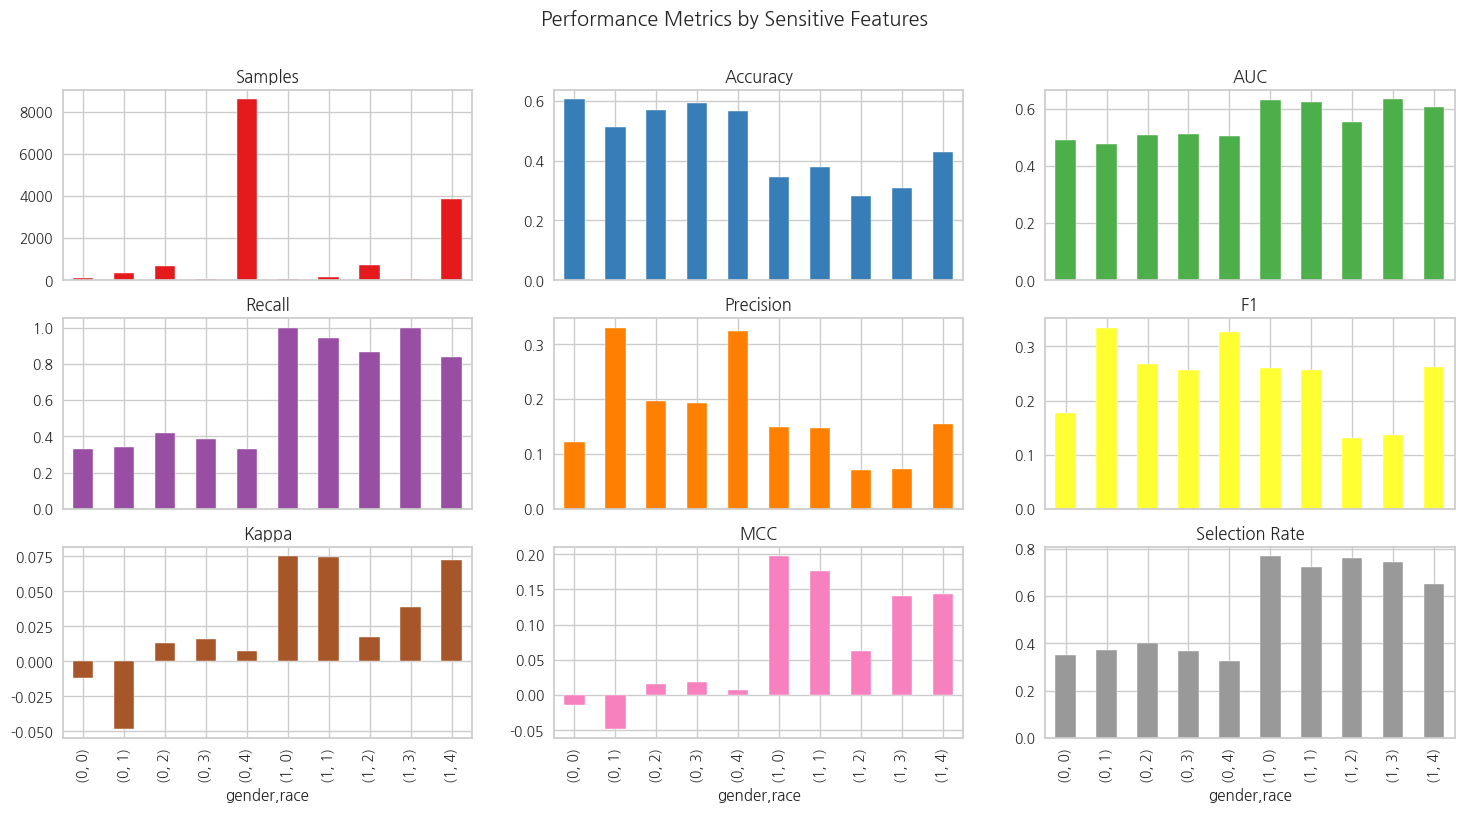

In [21]:
%%capture
lf.lh_fairness(project,project_type,dataset,model,sensitive_features)

In [16]:
%%capture
lf.model_bias_check(project,project_type,dataset, sensitive_features,train_size,prediction,model)

Json id 652 로 저장 완료됨
Json id 653 로 저장 완료됨

편향 전후 비교

편향 제거 이전:
      date     col_nm  demographic_parity_difference  \
0  2024-10-18     all            0.462205              
1  2024-10-18  gender            0.346402              
2  2024-10-18    race            0.159876              

   demographic_parity_ratio  equalized_odds_difference  equalized_odds_ratio  
0          0.407430                  0.697368                 0.302632        
1          0.484879                  0.517264                 0.381217        
2          0.724614                  0.193731                 0.667889        

 ----------------------------------------------------------------------------------------------------

편향 제거 이후:
      date     col_nm  demographic_parity_difference  \
0  2024-10-18     all            0.191065              
1  2024-10-18  gender            0.009556              
2  2024-10-18    race            0.078261              

   demographic_parity_ratio  equalized_odds_difference  e

,date,col_nm,demographic_parity_difference,demographic_parity_ratio,equalized_odds_difference,equalized_odds_ratio
0,2024-10-18,all,0.191065,0.258667,0.625000,0.071295
1,2024-10-18,gender,0.009556,0.946694,0.278237,0.364026
2,2024-10-18,race,0.078261,0.593548,0.274590,0.435786
